In [1]:
import pandas as pd
import numpy as np
import sys
import os

import time, enum, math
import pylab as plt
import random

from state import State
from Agent import MyAgent
from NetworkInformationDiffusionModel import NetworkInformationDiffusionModel
from Visualization import Visualization
from Data import Data

import networkx as nx

Loading BokehJS ...

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Post = {'author':2 , 'content': 'A positive Trump post', 'type': 0, 'party_mention': None, 'pov': 0, 'emotion_score':{}}
cmap = ["orange", "red", "blue", 'green', 'grey']
states = ['origin', 'received', 'not-received', 'spreader', 'distinterested']
colors = dict(zip(cmap, states))
colors

{'orange': 'origin',
 'red': 'received',
 'blue': 'not-received',
 'green': 'spreader',
 'grey': 'distinterested'}

In [4]:
def compute_share_prob(data, potential_users):
    
    user_id = None
    
    sharing_prob = potential_users['user_activity'] * potential_users['privacy_preference']
    
    # 50% of the times make a random selection of author
    if(random.random() > 0.50):
        user_id = int(data.sample(1)['id'].values[0])
        
    else:
        user_id = int(sharing_prob.idxmax())
        
    return user_id
    
def pick_an_author(data, post):
    
    issue_id = post[0]
    post_stance = post[1]
    issue_mentioned = 'issue_' + str(int(issue_id))
    user_id = None
    
    if data[data[issue_mentioned] <= 0].shape[0] == 0 or data[data[issue_mentioned] >= 0].shape[0] == 0:
        return None
    
    agent_inclination = data[issue_mentioned]
    if(post_stance >= 0):
        potential_users = data[data[issue_mentioned] >= 0]
        selected_author = compute_share_prob(data, potential_users)
    
    else:
        
        potential_users = data[data[issue_mentioned] < 0]
        selected_author = compute_share_prob(data, potential_users)
    
    
    return selected_author

In [5]:
def compare_data(df, data, attr):
    
    for i in range(df.shape[0]):
        if(df.iloc[i][attr] != data.iloc[i][attr]):
            print("old value ", df.iloc[i][attr], " \t New value", data.iloc[i][attr])

def update_user_activity(data, G, user, agg_sanct):
    
    user_data = data.iloc[user]
    
    old_user_activity = user_data['user_activity']
    
    ## NEED TO CHANGE THIS FORMULA TO BE SOMETHING MORE MEANINGFUL
    new_user_activity = old_user_activity + (agg_sanct * 0.01)
    
    #Update the user activity with the new value (a bounded value between 0 and 1)
    new_user_activity = max(min(1, new_user_activity), 0)
    #print("Updating ", user, "\t", old_user_activity, "\t", new_user_activity, "\t", agg_sanct)
    #data.at[user, 'user_activity'] = new_user_activity
    
    #print("Here ", data['user_activity'].sum(), "\t", G.nodes[user]['user_activity'])
    
    data['user_activity'].iloc[user] = new_user_activity
    G.nodes[user]['user_activity'] = new_user_activity
    
#     print("old_user_activity ", old_user_activity)
#     print("user_activity", new_user_activity, " agg_sanct ", agg_sanct)
    
#     print("Here ", data['user_activity'].sum(), "\t", G.nodes[user]['user_activity'])
    
    
    return data, G
    
def attitude_shift(sanction_score, att_diff, author_inclination, reciever_inclination):
    
    attitude_shift = sanction_score * att_diff
    if(author_inclination >= reciever_inclination):
        new_user_incl = author_inclination - attitude_shift
    else:
        new_user_incl = author_inclination + attitude_shift
        
    return new_user_incl


def update_user_satisfaction(data, G, user, agg_sanct):
    
    user_data = data.iloc[user]
    
    old_user_satisfaction = user_data['user_satisfaction']
    
    ## NEED TO CHANGE THIS FORMULA TO BE SOMETHING MORE MEANINGFUL
    new_user_satisfaction = old_user_satisfaction + (agg_sanct * 0.01)
    
    data['user_satisfaction'].iloc[user] = new_user_satisfaction
    G.nodes[user]['user_satisfaction'] = new_user_satisfaction
    
#     print("old_user_satisfaction ", old_user_satisfaction)
#     print("user_satisfaction", new_user_satisfaction, " agg_sanct ", agg_sanct)
    
#     print("Here ", data['user_satisfaction'].sum(), "\t", G.nodes[user]['user_satisfaction'])
#     #print("Here ", data['user_satisfaction'].sum())
    
    #print("Here: ", new_user_satisfaction)
#     sys.exit()
    
    return data, G
    
def update_user_preferences(sG, G, data, issue_id, lower_attd_th, upper_attd_th):
    
    labels = nx.get_edge_attributes(sG,'weight')
    outgoing = list(set([x[0] for x in labels.keys()]))
    incoming = list(set([x[1] for x in labels.keys()]))
    
    for n in incoming:
        agg_sanct = sum([labels[x] for x in labels if x[1] == n])
        data, G = update_user_activity(data, G, n, agg_sanct)
        data, G = update_user_satisfaction(data, G, n, agg_sanct)
        
    #print("agg_sanct : ", agg_sanct)
#     print("Here ", data['user_activity'].sum())
#     sys.exit()
    for node in incoming:
        
        edges = sG.in_edges(node, data=True)
        gama = 0
        
        for x in edges:
            reciever = x[0]
            author = x[1]
            sanction_score = x[2]['weight']

            reciever_inclination = data[data['id'] == reciever]['issue_' + str(issue_id)].values[0]
            author_inclination = data[data['id'] == author]['issue_' + str(issue_id)].values[0]
            att_diff =  abs(reciever_inclination - author_inclination)
            
#             if sanction_score > 0:
#                 sanction_score = 2 * sanction_score
                
            flag = 0
        
            if(sjt_flag == False):
                 
                flag = 1
                new_user_incl = attitude_shift(sanction_score, att_diff, author_inclination, reciever_inclination)
                   
            else:
                # If attitude difference is within the latitude of acceptance change attitude towards the provided sanction 
                if(att_diff <= lower_attd_th):

                    flag = 1
                    new_user_incl = attitude_shift(sanction_score, att_diff, author_inclination, reciever_inclination)

                elif(att_diff >= upper_attd_th):

                    flag = 1
                    new_user_incl = attitude_shift((-1) * sanction_score, att_diff, author_inclination, reciever_inclination)

            if(flag == 1):

                if(new_user_incl <= -1):
                    new_user_incl = -1
                elif(new_user_incl >= 1):
                    new_user_incl = 1

                data['issue_' + str(issue_id)].iloc[author] = new_user_incl
                G.nodes[author]['issue_' + str(issue_id)] = new_user_incl
                
    return data, G

def update_pol_pol_in_graph(data, G):
    
    for n in G:
        G.nodes[n]['pol_inclination'] = data.iloc[n]['pol_inclination']
        
    return G


def run_simulation(post, G, steps):

    model = NetworkInformationDiffusionModel(post, G, se_flag, se_threshold, weight_flag)
    for i in range(steps):

        model.step(i)
        #agent_state = model.datacollector.get_agent_vars_dataframe()
        #X = pd.pivot_table(agent_state.reset_index(), index='Step', columns='State', aggfunc=np.size, fill_value=0)  
        
    #print(model.datacollector.get_agent_vars_dataframe())
    agent_state = model.datacollector.get_agent_vars_dataframe()
    
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    agents = model.agents
    
    return model, states, agents, model.G, model.G_share, agent_state

def start_simulation(data, G, post_conf, n_issues, lower_attd_th, upper_attd_th):
    
    steps=50
    SimModel, states, agents, AgentGraphs, SancGraphs, AgentStates, runtime = {}, [], [], [], [], [], []
    network_homophily = []
    polarization = []
    user_satisfaction = []
    polarity = []
    avg_polarity = []
    i = 0
    sharing_details = []

    for j, post in post_conf.iterrows():

        print(i, end="\r")
        i+=1
        
        pc = (post['issue'], post['stance'])

        st=time.time()
        author_id = pick_an_author(data, pc)
        #author_id = int(post['author_id'])
        
        if(author_id == None):
            continue

        post = dict()
        post['author'] = author_id
        post['issue'] = int(pc[0])
        post['stance'] = pc[1]

        SimModel[j], state, agent, G_agents, G_sanctions, agent_state = run_simulation(post, G, steps)
        
        et = time.time()
        rt = round(et-st, 6)

        states.append(state) 
        agents.append(agent)
        AgentGraphs.append(G_agents)
        SancGraphs.append(G_sanctions)
        AgentStates.append(agent_state)
        runtime.append(rt)

        author = author_id
        #received_agents_count = sum([1 for x in state if x == 1])
        not_received_agents_count = sum([1 for x in state if x == 2])
        spreader_agents_count = sum([1 for x in state if x == 3])
        disinterested_agents_counts = sum([1 for x in state if x == 4])
        received_agents_count = spreader_agents_count + disinterested_agents_counts

        #print(state)
        sharing_details.append([pc[0], round(pc[1], 6), author_id, received_agents_count, not_received_agents_count, spreader_agents_count, disinterested_agents_counts])
        #print(sharing_details)

#         Visualization().plot_sim_network(G_agents, state)
#         Visualization().plot_sanction_graph(G_sanctions)

        # Update user preferences based on. sanctions received from other agents
        data, G_agents = update_user_preferences(G_sanctions, G_agents, data, post['issue'], lower_attd_th, upper_attd_th)
        
        
        pol_inclination = Data.get_agent_pol_inclinations(data, n_issues)
        data['pol_inclination'] = pol_inclination
        
        G_agents = update_pol_pol_in_graph(data, G_agents)
        
        net_user_satisfaction = data['user_satisfaction'].mean()
        user_satisfaction.append(net_user_satisfaction)
        
        pol = round(sum([x*x for x in data['pol_inclination']])/data.shape[0], 6)
        avg_pol = round(data['pol_inclination'].mean(), 6)
        
        temp_G = G.copy()
        
        node_attr = data.set_index('id').to_dict('index')
        nx.set_node_attributes(temp_G, node_attr)
        
        for n in temp_G.nodes:
            if(node_attr[n]['pol_inclination'] >= 0.65 or node_attr[n]['pol_inclination'] <= -0.65):
                node_attr[n]['pol_inclination_grp'] = -1
            elif((node_attr[n]['pol_inclination'] > -0.65 or node_attr[n]['pol_inclination'] <= -0.25) and (node_attr[n]['pol_inclination'] >= 0.25 or node_attr[n]['pol_inclination'] < 0.65)):
                node_attr[n]['pol_inclination_grp'] = 0
            elif((node_attr[n]['pol_inclination'] > -0.25 or node_attr[n]['pol_inclination'] < 0.25) and (node_attr[n]['pol_inclination'] > 0.25 or node_attr[n]['pol_inclination'] < 0.65)):
                node_attr[n]['pol_inclination_grp'] = 0
            
        nx.set_node_attributes(temp_G, node_attr)
        
        hom = nx.attribute_assortativity_coefficient(temp_G, "pol_inclination_grp")
        polarization.append(pol)
        network_homophily.append(hom)
        polarity.append(avg_pol)
        
#         print(hom)
#         if(i == 10):
#             sys.exit()

    return data, G_agents, sharing_details, polarization, network_homophily, polarity, user_satisfaction

    #final_sanc_graph = Visualization().aggregate_sanction_graphs(SancGraphs)
    #G_sharing = Visualization().get_sharing_graphs(G, final_sanc_graph)  
    
def save_results_to_dir(run, epoch, data, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction):
    
    results_df = pd.DataFrame(sharing_details, columns = ['party_mentioned', 'post_stance', 'author_id', 'num_of_agents_received', 'num_of_agents_not_received', 
                                                                  'num_of_spreader_agents', 'num_of_disinterested_agents'])
    
    results_df['network_polarization'] = net_polarization
    results_df['network_homophily'] = network_homophily
    results_df['network_polarity'] = polarity
    results_df['user_satisfaction'] = user_satisfaction
    
    mypath = '../results/sharing_details/'
    results_df.to_csv(mypath + 'results_' + str(run) + '.csv')
    #data.to_csv(mypath + 'network_data_' + str(epoch) + '.csv')
    
    return

def save_graph(run, i, polarization, flag):

    fig, ax = plt.subplots()
    plt.plot(range(len(polarization)), polarization)
    if(flag == 3):
        filepath = '../results/results_' + str(run) + '/user_satisfaction_' + str(i) +'.jpg'
    elif(flag == 2):
        filepath = '../results/results_' + str(run) + '/network_polarity_' + str(i) +'.jpg'
    elif(flag == 1):
        filepath = '../results/results_' + str(run) + '/polarization_' + str(i) +'.jpg'
    elif(flag == 0):
        filepath = '../results/results_' + str(run) + '/network_homophily_' + str(i) +'.jpg'
        
    plt.savefig(filepath)
    plt.show()
    
    return
    
def save_data(run, i, data, flag):
    
    mypath = '../results/results_' + str(run) + '/'
        
    if os.path.isdir(mypath) == False:
        os.mkdir(mypath)
        
    if(flag == 1):
        data.to_csv(mypath + 'initial_data.csv')
    elif(flag == 2):
        data.to_csv(mypath + 'final_data_' + str(i) +'.csv')
    
    return

In [6]:
Data = Data()

In [7]:
# se_flag = False
# sjt_flag= True
# se_threshold = 0
# lower_attd_th = 0.6
# upper_attd_th = 1.4

n_issues= 6
initial_graph, initial_data = Data.get_social_network(n_issues)
post_conf = Data.generate_posts(5000, n_issues)

# saved_df = pd.read_csv('../results/new_results_tolerance/results_0/initial_data.csv')
# initial_graph = Data.get_saved_network(saved_df)
# initial_data = saved_df.copy()
# sharing_details = pd.read_csv('../results/new_results_tolerance/results_0/results_tollorant_Most.csv')

# rep = abs(data[data['pol_inclination'] < 0]['pol_inclination'].sum())
# dem = abs(data[data['pol_inclination'] > 0]['pol_inclination'].sum())
# initial_pol = round((rep + dem)/data.shape[0], 6) 
# initial_homophily = nx.attribute_assortativity_coefficient(G, "pol_inclination")
# initial_pol, initial_homophily

# se_threshold = 0.5
# lower_attd_th = 0.5
# upper_attd_th = 1.5

In [8]:
# post_conf = sharing_details[['party_mentioned', 'post_stance', 'author_id']].rename(columns = {'party_mentioned': 'issue'})
# post_conf

In [9]:
# initial_data.to_csv('../results/initial_data.csv')
# post_conf.to_csv('../results/post_conf.csv')

### Exp 1: Varying Selective Exposure

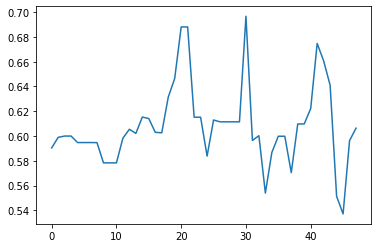

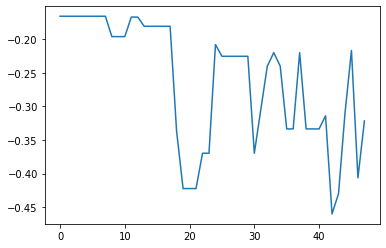

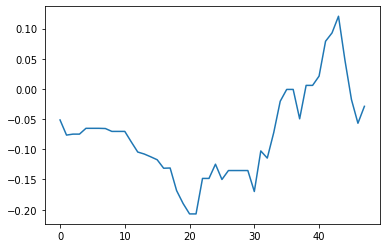

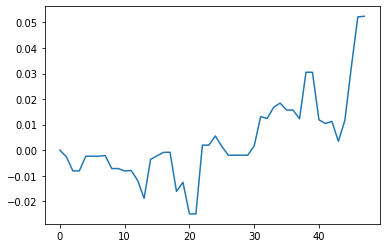

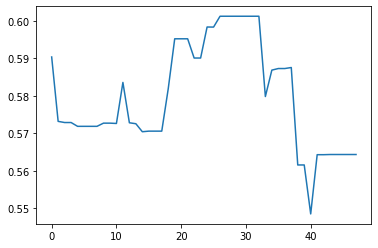

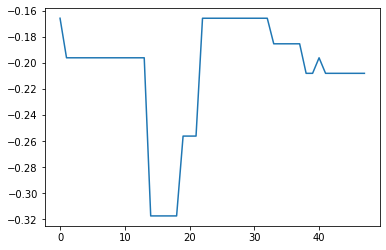

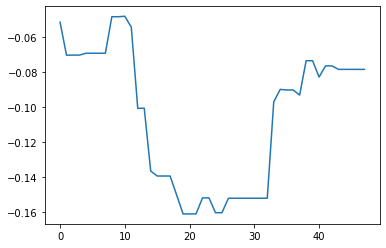

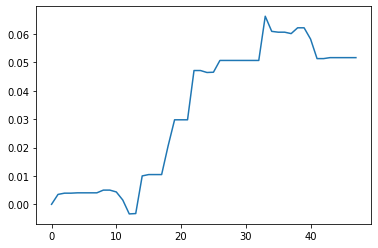

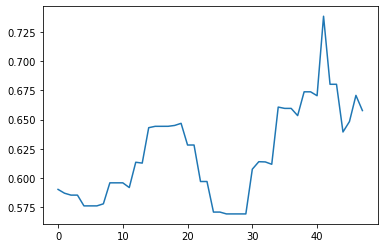

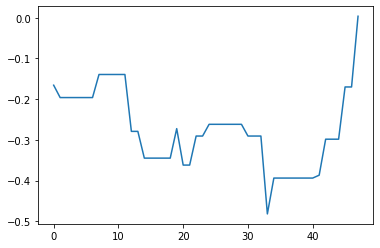

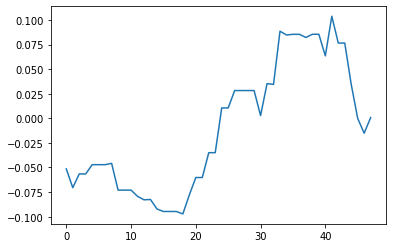

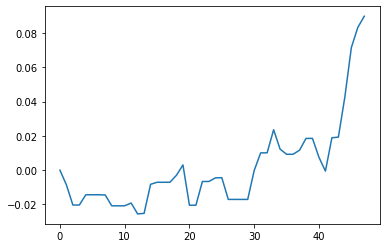

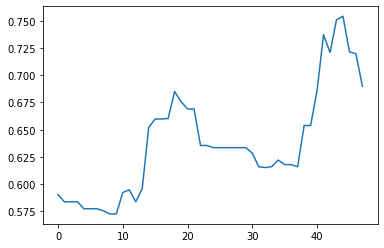

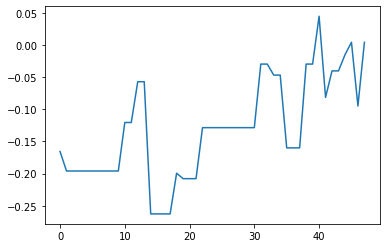

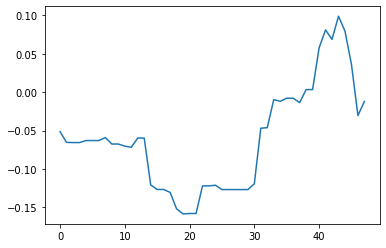

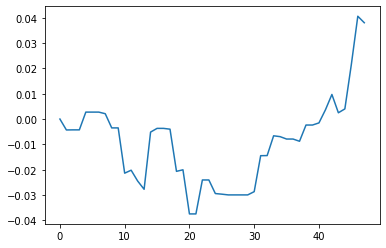

In [10]:
#number_of_issues = [2,4,8,16]
num_issues = 6
sjt_flag= True
lower_attd_th = 0.6
upper_attd_th = 1.4
se_flags = [False, True, True, True]
se_thresholds = [0, 0.4, 1.0, 1.6]
weight_flag = None
# n_issues = 6
# initial_graph, initial_data = Data.get_social_network(n_issues)
# post_conf = Data.generate_posts(4000, num_issues)

k=1
for i in range(4):

    se_threshold = se_thresholds[i]
    se_flag = se_flags[i]

    data = initial_data.copy()
    G = initial_graph.copy()

    run = str(k) + str(i)
    #run = i

    rep = abs(data[data['pol_inclination'] < 0]['pol_inclination'].sum())
    dem = abs(data[data['pol_inclination'] > 0]['pol_inclination'].sum())
    initial_pol = round((rep + dem)/data.shape[0], 6) 
    initial_homophily = nx.attribute_assortativity_coefficient(G, "pol_inclination")

    save_data(run, 0, initial_data, 1)
#     for i in range(2):

    data = initial_data.copy()
    G = initial_graph.copy()
    data, G, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction = start_simulation(data, G, post_conf, n_issues, lower_attd_th, upper_attd_th)
    net_polarization = initial_pol + net_polarization
    network_homophily = initial_homophily + network_homophily
    save_results_to_dir(run, i, data, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction)
    save_graph(run, i, net_polarization, 1)
    save_graph(run, i, network_homophily, 0)
    save_graph(run, i, polarity, 2)
    save_graph(run, i, user_satisfaction, 3)
    save_data(run, i, data, 2)

### Exp 2: Balanced Coverage on Issues

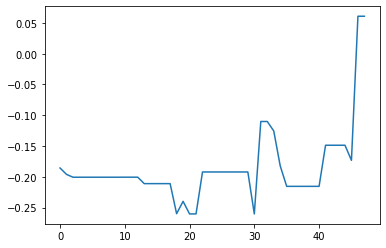

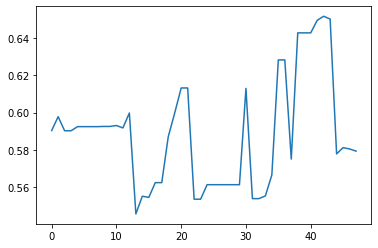

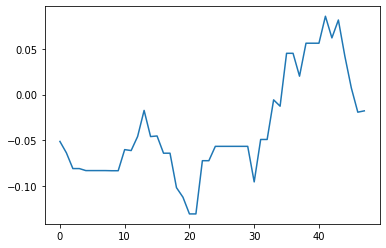

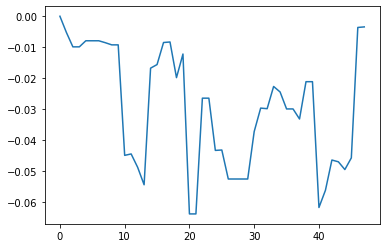

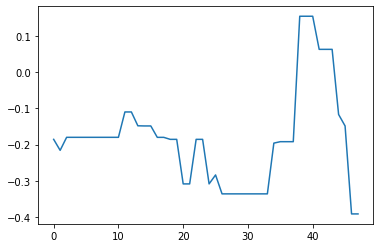

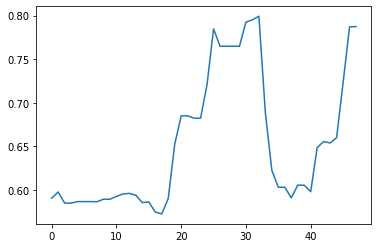

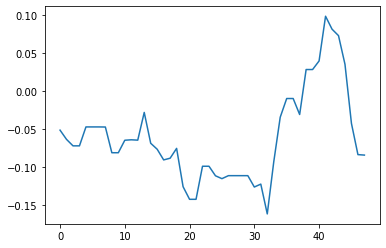

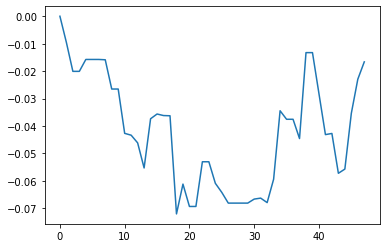

In [11]:
#num_issues = [2,4,8,16]
se_flag = False
sjt_flag= True
se_threshold = 0
lower_attd_th = 0.6
upper_attd_th = 1.4
weight_flag = None

n_issues= 6
#initial_graph, initial_data = Data.get_social_network(n_issues)
#post_conf = Data.generate_posts(4000, n_issues)
# num_issues = 6
k = 2
for i in range(2):

    #n_issues = num_issues[i]

    if(i == 0):
        weight_flag = 'odd'
        #initial_graph, initial_data = Data.get_social_network(num_issues)
        #post_conf = Data.generate_posts(415, num_issues)
        #print(post_conf['issue'].shape, post_conf['issue'].value_counts())
    elif(i == 1):
        weight_flag = 'even'
        #initial_graph, initial_data = Data.get_social_network(2)
        #initial_graph, initial_data = Data.add_issue_stance(initial_data, initial_graph, [2,3], num_issues)
        #post_conf = Data.generate_skewed_posts(415, num_issues, 0, 0.33)
        #print(post_conf.shape, post_conf['issue'].value_counts())
#     elif(i == 2):
#         #initial_graph, initial_data = Data.get_social_network(4)
#         #initial_graph, initial_data = Data.add_issue_stance(initial_data, initial_graph, [4,5,6,7], n_issues)
#         post_conf = Data.generate_skewed_posts(415, num_issues, 0, 0.67)
#         #print(post_conf['issue'].shape, post_conf['issue'].value_counts())

    data = initial_data.copy()
    G = initial_graph.copy()

    run = str(k) + str(i)
    #run = i

    rep = abs(data[data['pol_inclination'] < 0]['pol_inclination'].sum())
    dem = abs(data[data['pol_inclination'] > 0]['pol_inclination'].sum())
    initial_pol = round((rep + dem)/data.shape[0], 6) 
    
    temp_G = G.copy()

    node_attr = data.set_index('id').to_dict('index')
    nx.set_node_attributes(temp_G, node_attr)

    for n in temp_G.nodes:
        node_attr[n]['pol_inclination'] = round(node_attr[n]['pol_inclination'], 1)

    #         print(temp_G.nodes)
    #print(node_attr)
    nx.set_node_attributes(temp_G, node_attr)
    
    initial_homophily = nx.attribute_assortativity_coefficient(temp_G, "pol_inclination")

    save_data(run, 0, initial_data, 1)
#     for i in range(2):

    data = initial_data.copy()
    G = initial_graph.copy()
    data, G, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction = start_simulation(data, G, post_conf, n_issues, lower_attd_th, upper_attd_th)
    net_polarization = initial_pol + net_polarization
    network_homophily = initial_homophily + network_homophily
    save_results_to_dir(run, i, data, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction)
    save_graph(run, i, network_homophily, 0)
    save_graph(run, i, net_polarization, 1)
    save_graph(run, i, polarity, 2)
    save_graph(run, i, user_satisfaction, 3)
    save_data(run, i, data, 2)

In [12]:
# saved_df = pd.read_csv('../results/initial_data.csv')
# post_conf = pd.read_csv('../results/post_conf.csv')
# initial_graph = Data.get_fb_network(saved_df)

In [13]:
# initial_graph.nodes

### Exp 3: Varying Tolerance level in users

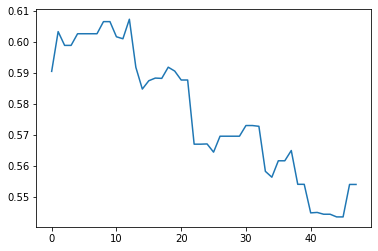

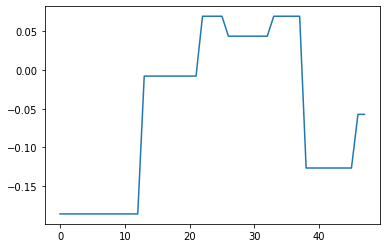

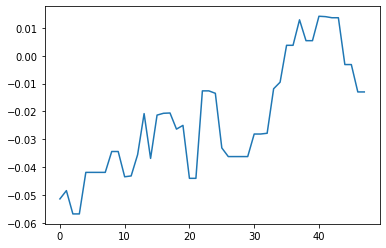

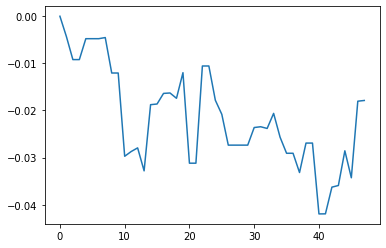

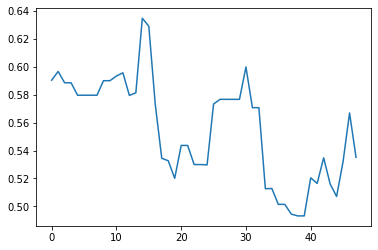

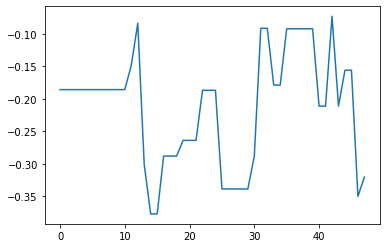

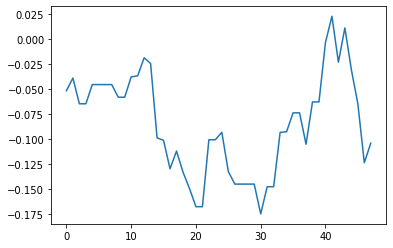

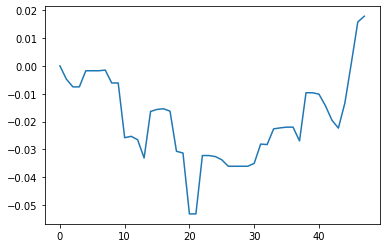

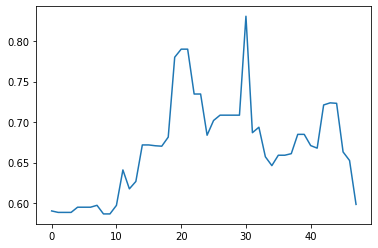

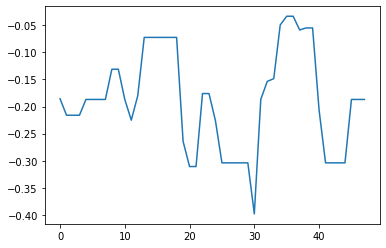

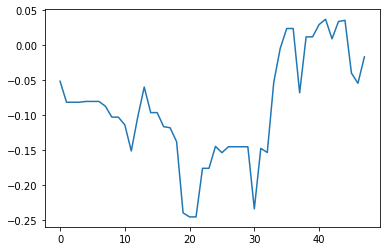

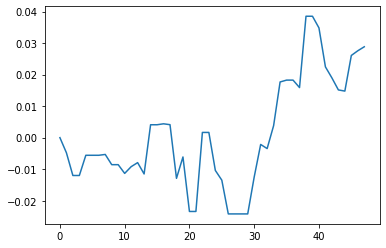

In [14]:
#number_of_issues = [2,4,8,16]
se_flag = False
sjt_flag= True
se_threshold = 0
weight_flag = None

# n_issues= 6
# initial_graph, initial_data = Data.get_social_network(n_issues)
# initial_data = pd.read_csv('../results/initial_data.csv')
# initial_graph =  Data.get_fb_network(initial_data)
# post_conf = Data.generate_posts(4000, n_issues)

l_attd_th = [0.3, 0.6, 0.9]
u_attd_th = [1.7, 1.4, 1.1]

# for k in range(5):
k = 3
for i in range(3):

    #n_issues = num_issues[i]
    lower_attd_th = l_attd_th[i]
    upper_attd_th = u_attd_th[i]

#     if(i == 0):
# #         initial_graph, initial_data = Data.get_social_network(num_issues)
#         saved_df = pd.read_csv('../results/initial_data.csv')
#         post_conf = pd.read_csv('../results/post_conf.csv')
#         initial_graph = Data.get_saved_network(saved_df)
#         initial_data = saved_df.copy()
# #         sharing_details = pd.read_csv('../results/results_0/results_tollorant_Most.csv')
# #         post_conf = sharing_details[['party_mentioned', 'post_stance', 'author_id']].rename(columns = {'party_mentioned': 'issue', 'post_stance': 'stance'})
# #         #print(post_conf['issue'].shape, post_conf['issue'].value_counts())
        
#     elif(i == 1):
#         #initial_graph, initial_data = Data.get_social_network(2)
#         #initial_graph, initial_data = Data.add_issue_stance(initial_data, initial_graph, [2,3], n_issues)
#         #post_conf = Data.generate_skewed_posts(415, num_issues, 0, 0.33)
        
#         saved_df = pd.read_csv('../results/results_1/initial_data.csv')
#         initial_graph = Data.get_saved_network(saved_df)
#         initial_data = saved_df.copy()
#         sharing_details = pd.read_csv('../results/results_1/results_tollorant_Mid.csv')
#         post_conf = sharing_details[['party_mentioned', 'post_stance', 'author_id']].rename(columns = {'party_mentioned': 'issue', 'post_stance': 'stance'})
        
#         #print(post_conf.shape, post_conf['issue'].value_counts())
        
#     elif(i == 2):
#         #initial_graph, initial_data = Data.get_social_network(4)
#         #initial_graph, initial_data = Data.add_issue_stance(initial_data, initial_graph, [4,5,6,7], n_issues)
#         #post_conf = Data.generate_skewed_posts(415, num_issues, 0, 0.67)
        
#         saved_df = pd.read_csv('../results/results_2/initial_data.csv')
#         initial_graph = Data.get_saved_network(saved_df)
#         initial_data = saved_df.copy()
#         sharing_details = pd.read_csv('../results/new_results_tolerance/results_2/results_tollorant_Least.csv')
#         post_conf = sharing_details[['party_mentioned', 'post_stance', 'author_id']].rename(columns = {'party_mentioned': 'issue', 'post_stance': 'stance'})
        
        #print(post_conf['issue'].shape, post_conf['issue'].value_counts())

    data = initial_data.copy()
    G = initial_graph.copy()

    run = str(k) + str(i)
#     run = i

    rep = abs(data[data['pol_inclination'] < 0]['pol_inclination'].sum())
    dem = abs(data[data['pol_inclination'] > 0]['pol_inclination'].sum())
    initial_pol = round((rep + dem)/data.shape[0], 6) 
    
    temp_G = G.copy()
        
    node_attr = data.set_index('id').to_dict('index')
    nx.set_node_attributes(temp_G, node_attr)

    for n in temp_G.nodes:
        node_attr[n]['pol_inclination'] = round(node_attr[n]['pol_inclination'], 1)

#         print(temp_G.nodes)
    #print(node_attr)
    nx.set_node_attributes(temp_G, node_attr)
    initial_homophily = nx.attribute_assortativity_coefficient(temp_G, "pol_inclination")

    save_data(run, 0, initial_data, 1)
#     for i in range(2):

    data = initial_data.copy()
    G = initial_graph.copy()
    data, G, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction = start_simulation(data, G, post_conf, n_issues, lower_attd_th, upper_attd_th)
    net_polarization = initial_pol + net_polarization
    network_homophily = initial_homophily + network_homophily
    save_results_to_dir(run, i, data, sharing_details, net_polarization, network_homophily, polarity, user_satisfaction)
    save_graph(run, i, net_polarization, 1)
    save_graph(run, i, network_homophily, 0)
    save_graph(run, i, polarity, 2)
    save_graph(run, i, user_satisfaction, 3)
    save_data(run, i, data, 2)